In [1]:
from os import getenv
import numpy as np
import matplotlib.pylab as plt
from time import time

from rss.client import rssFromS3

# Authentication
If the bucket is public you don't need to define `client_kwargs`. Otherwise use `python-dotenv` to get
credentials from a `.env` file next to the notebook.

### Loading AWS Credentials

Here we use the `python-dotenv` library to load our AWS access credentials from a `.env` file contained
in the same folder with our notebooks. iPython magic commands are used here. Keep in mind
if you already have AWS credentials in your environment variables the `.env` will be ignored.

If you already have different credentials and you want to load from the `.env` file, change `%dotenv` magic
function to `%dotenv -o` which will override the existing credentials.

In [2]:
%load_ext dotenv
%dotenv

region_name = 'us-east-1'
aws_key = getenv('AWS_ACCESS_KEY_ID')
aws_secret = getenv('AWS_SECRET_ACCESS_KEY')

client_kwargs = {'aws_access_key_id': aws_key,
                 'aws_secret_access_key': aws_secret}

#rss = rssFromS3('geophysics-on-cloud/poseidon/seismic/rss/psdn11_TbsdmF_full_w_AGC_Nov11', client_kwargs)
rss = rssFromS3('geophysics-on-cloud/poseidon/seismic/rss/psdn11_TbsdmF_Near_Nov_11_32bit', client_kwargs)
#rss = rssFromS3('geophysics-on-cloud/poseidon/seismic/rss/psdn11_TbsdmF_Mid_Nov_11_32bit', client_kwargs)
#rss = rssFromS3('geophysics-on-cloud/poseidon/seismic/rss/psdn11_TbsdmF_Far_Nov_11_32bit', client_kwargs)

Connection complete.


### Header information
The rss object contains the header information, x/y (easting and northing) and the 
il/xl coordinates. If you're interested, the CRS is GDA95, which is EPSG:28355. This 
data is for each trace in the file, in the order the trace occured in the original 
SEGY data.

In [3]:
#x/y header data, with coordinate scalar applied
rss.xy

array([[ 416132., 8447595.],
       [ 416123., 8447603.],
       [ 416113., 8447611.],
       ...,
       [ 409187., 8537523.],
       [ 409178., 8537531.],
       [ 409168., 8537539.]])

In [4]:
#inline/xline header data
rss.ilxl

array([[ 983,  504],
       [ 983,  505],
       [ 983,  506],
       ...,
       [4419, 5554],
       [4419, 5555],
       [4419, 5556]], dtype=int64)

### Loading individual traces
You can load an individual trace by it's inline/xline coordinate. Understand that loading a 
single trace will also being down an entire line from storage, so it won't be faster than 
loading a line. However, neighbouring traces will be cached locally.

Elapsed Time (loading) :  1.1687774658203125
Elapsed Time (caching) :  0.06805992126464844


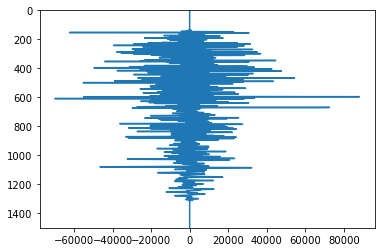

In [5]:
st = time()
trace, is_live = rss.trace(1337, 2000)
print ("Elapsed Time (loading) : ", time() - st)

st = time()
trace, is_live = rss.trace(1337, 2000)
print ("Elapsed Time (caching) : ", time() - st)

plt.figure()
plt.plot(trace, np.arange(len(trace)))
plt.ylim([len(trace),0])
plt.show()

### Getting slices:
The data is optimized for reads in the inline and crossline directions, 
and reads are cached.

Elapsed Time (loading) :  0.556396484375
Elapsed Time (loading):  0.5369617938995361
Elapsed Time (caching):  0.11459732055664062


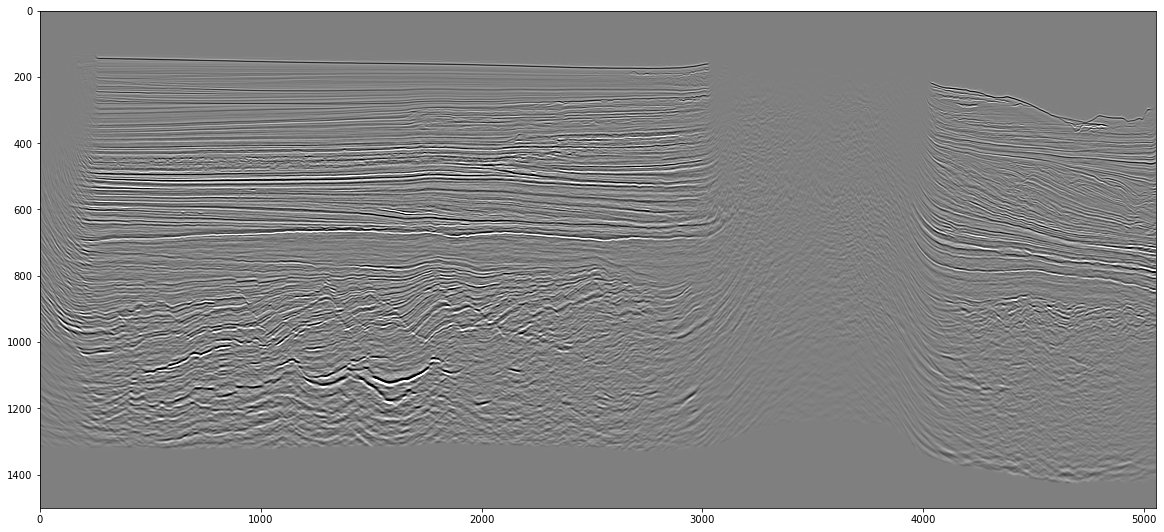

In [6]:
st = time()
inline, mask = rss.line(2002, sort_order='inline')
print ("Elapsed Time (loading) : ", time() - st)

st = time()
inline, mask = rss.line(2003, sort_order='inline')
print ("Elapsed Time (loading): ", time() - st)

st = time()
inline, mask = rss.line(2002, sort_order='inline')
print ("Elapsed Time (caching): ", time() - st)

plt.figure(figsize=(20,20))
plt.imshow(inline, cmap='gray', 
           interpolation='bicubic',
           aspect=1.5,
           vmin=-2*np.std(inline[~mask]), vmax=2*np.std(inline[~mask]))
plt.show()

Elapsed Time (loading):  1.2764079570770264
Elapsed Time (loading):  0.5179436206817627
Elapsed Time (caching):  0.09908437728881836


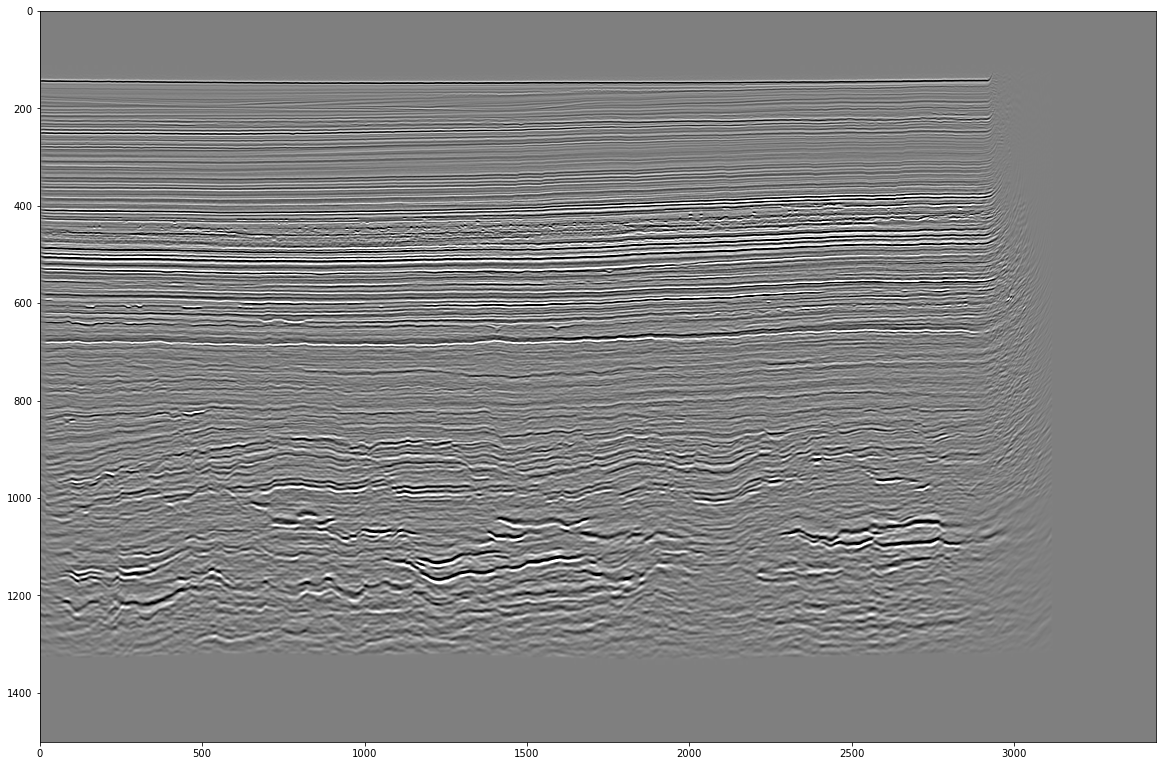

In [7]:
from time import time
st = time()
inline, mask = rss.line(1100, sort_order='crossline')
print ("Elapsed Time (loading): ", time() - st)

st = time()
inline, mask = rss.line(1101, sort_order='crossline')
print ("Elapsed Time (loading): ", time() - st)

st = time()
inline, mask = rss.line(1100, sort_order='crossline')
print ("Elapsed Time (caching): ", time() - st)

plt.figure(figsize=(20,20))
plt.imshow(inline, cmap='gray', 
           aspect=1.5, 
           interpolation='bicubic',
           vmin=-2*np.std(inline[~mask]), vmax=2*np.std(inline[~mask]))
plt.show()

### Map x/y -> inline/xline
This is really slow the first time you run it, and probably uses a bunch of 
memory, but gives you a function to find nearest neighbours to a specific x/y
location. 

In [8]:
from time import time
st = time()
rss.query_by_xy(rss.xy[1337,:])
print ("Elapsed time (loading): ", time() - st)

Assembling a tree to map il/xl to x/y. 
This could take a couple of minutes, 
But only happens one time.
Elapsed time (loading):  5.612824440002441


In [9]:
from time import time
st = time()
dist, ilxl = rss.query_by_xy(rss.xy[1337,:], k=8)
print ("Elapsed time (cached) : ", time() - st)

Elapsed time (cached) :  0.0


In [10]:
# the distance in meters from the x/y location to the k nearest grid locations:
print(dist)
# the inline/xline coordinates
print(ilxl)

[[ 0.         12.04159458 12.80624847 18.43908891 21.84032967 23.08679276
  24.8394847  25.61249695]]
[array([[ 983, 1841],
       [ 983, 1840],
       [ 983, 1842],
       [ 984, 1841],
       [ 984, 1840],
       [ 984, 1842],
       [ 983, 1839],
       [ 983, 1843]], dtype=int64)]


In [11]:
# get an array of traces around a point
st = time()
traces = np.vstack([rss.trace(*i)[0] for i in ilxl[0]]).T
print ("Elapsed Time (loading) : ", time() - st)

Elapsed Time (loading) :  2.0423619747161865
